# Basic Preprocessing and Connected Components

In [21]:
from tifffile import imread, imsave
import numpy as np
import matplotlib.pyplot as plt

exp_name = 'cell_detection_9'
n_components = 2

def show_image(img_3d, slice_z):
    if slice_z:
        img_slice = img_3d[slice_z, :, :]
    else:
        img_slice = img_3d
            
    plt.imshow(img_slice, cmap=plt.cm.gray)
    plt.figure(figsize=(800,800))
    plt.show()

## Image Histogram

In [22]:
img = imread('{}.tiff'.format(exp_name))

fig1, p1 = plt.subplots()

p1.hist(img.flatten(), bins=256, range=[0,5000])
p1.set_xlabel('Intensity')
p1.set_ylabel('Voxel Count')
p1.set_title('Image Histogram - Low Intensity')
fig1.savefig('hist_low_{}.png'.format(exp_name))

fig2, p2 = plt.subplots()

p2.hist(img.flatten(), bins=256, range=[5000,img.max()])
p2.set_xlabel('Intensity')
p2.set_ylabel('Voxel Count')
p2.set_title('Image Histogram - High Intensity')
fig2.savefig('hist_high_{}.png'.format(exp_name))

shape_z, shape_y, shape_x = img.shape

12478.5


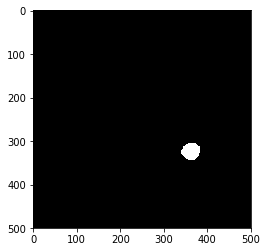

In [5]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.stats
import time

SOME_BIG_VALUE = img.max() + 1000

def gmm_img(data_points):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full').fit(data_points)
    cluster_labels = gmm.predict(data_points)
    cluster_centers = np.empty((n_components, len(data_points[0])))

    for i in range(n_components):
        density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i], allow_singular=True).logpdf(data_points)
        cluster_centers[i, :] = data_points[np.argmax(density)]
    
    cluster_int = [p[0] for p in cluster_centers]
    cluster_int.sort()
    
    max_intensity = cluster_int[::-1][0]
    medium_intensity = cluster_int[::-1][1]
    
    avg_intensity = (float(max_intensity) + float(medium_intensity))/2.0
    
    new_img = np.ndarray((shape_z, shape_y, shape_x))
    np.copyto(new_img, img)
    
    print(avg_intensity)
    
    new_img[img >= avg_intensity] = 255
    new_img[img < avg_intensity] = 0
    
    return new_img

start = time.clock()

uniq = np.unique(img, return_counts=True)
data_points = [p for p in zip(*uniq)]
gm_img = gmm_img(data_points)
imsave('{}-thresholded.tiff'.format(exp_name), gm_img.astype(np.uint8))
show_image(gm_img, 50)


# Erosion

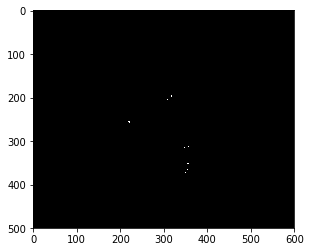

In [4]:
from skimage.morphology import binary_erosion

eroded_img = binary_erosion(gm_img)
show_image(eroded_img, 50)

## Connected Components

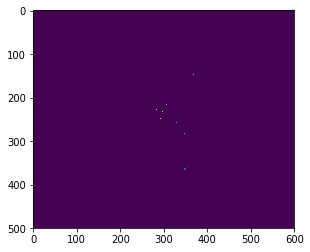

198
Predictions saved to CSV
2.6445600000000002


In [5]:
from skimage import measure
import math
import csv

if n_components == 2:
    cc_img = measure.label(gm_img, background=0)
else:
    cc_img = measure.label(eroded_img, background=0)
        
plt.imshow(cc_img[30, :, :])
plt.show()

centroids = [[round(x.centroid[0]), round(x.centroid[1]), round(x.centroid[2])] for x in measure.regionprops(cc_img)]

print(len(centroids))
    
with open('{}_predicted.csv'.format(exp_name), 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(centroids)

print('Predictions saved to CSV')
end = time.clock()
print(end - start)